In [1]:
!pip install torch torchvision matplotlib opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [17]:
import os
import cv2
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T

class SEMGrainDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_list = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_list[idx])
        mask_path = os.path.join(self.mask_dir, self.image_list[idx].replace(".png", "_mask.png"))

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Check if images or masks are empty and skip if they are
        if image is None or mask is None or image.size == 0 or mask.size == 0:
            print(f"Skipping empty or invalid image/mask: {self.image_list[idx]}")
            return None, None # Return None for both image and mask

        # Normalize and resize
        image = cv2.resize(image, (256, 256)) / 255.0
        mask = cv2.resize(mask, (256, 256)) / 255.0

        # Add channel dimension
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask

In [18]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True),
            )

        self.encoder1 = conv_block(1, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(128, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.decoder2(torch.cat([self.upconv2(b), e2], dim=1))
        d1 = self.decoder1(torch.cat([self.upconv1(d2), e1], dim=1))
        return torch.sigmoid(self.final(d1))


In [19]:
def collate_fn(batch):
    # Filter out None values
    batch = list(filter(lambda x: x is not None, batch))
    if len(batch) == 0:
        return None, None  # Return None for both images and masks if the batch is empty

    # Separate images and masks
    images, masks = zip(*batch)

    # Stack tensors if they exist and the list is not empty
    images = torch.stack(images, 0) if images and len(images) > 0 else None
    masks = torch.stack(masks, 0) if masks and len(masks) > 0 else None


    return images, masks

In [21]:
from torch.utils.data import DataLoader
import torch.optim as optim

# Setup
dataset = SEMGrainDataset("/content/drive/MyDrive/Datasets/Electron Microscopy Images/TSEM", "/content/drive/MyDrive/Datasets/Electron Microscopy Image Masks/TiO2_Masks_TSEM")
# Use the custom collate_fn in the DataLoader
train_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
model = UNet().cuda()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    # Keep the check for None batches in the training loop as a safeguard
    for images, masks in train_loader:
        # Skip batches with None values
        if images is None or masks is None:
            print(f"Skipping empty batch in epoch {epoch+1}")
            continue

        images, masks = images.cuda(), masks.cuda()

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/20 - Loss: 0.5109
Epoch 2/20 - Loss: 0.2862
Epoch 3/20 - Loss: 0.2753
Epoch 4/20 - Loss: 0.2721
Epoch 5/20 - Loss: 0.2681
Epoch 6/20 - Loss: 0.2668
Epoch 7/20 - Loss: 0.2481
Epoch 8/20 - Loss: 0.2949
Epoch 9/20 - Loss: 0.2682
Epoch 10/20 - Loss: 0.2438
Epoch 11/20 - Loss: 0.1985
Epoch 12/20 - Loss: 0.1574
Epoch 13/20 - Loss: 0.1330
Epoch 14/20 - Loss: 0.1250
Epoch 15/20 - Loss: 0.1163
Epoch 16/20 - Loss: 0.1127
Epoch 17/20 - Loss: 0.1077
Epoch 18/20 - Loss: 0.1048
Epoch 19/20 - Loss: 0.1024
Epoch 20/20 - Loss: 0.1020


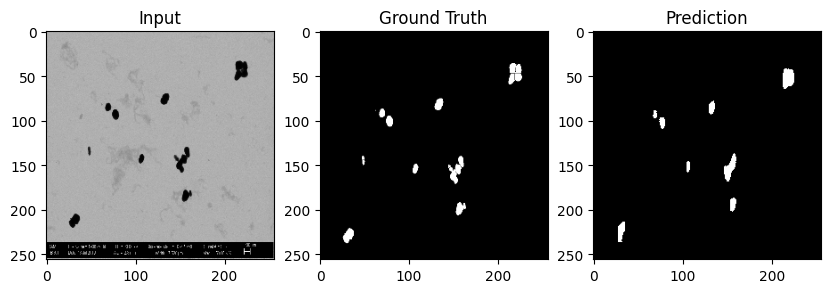

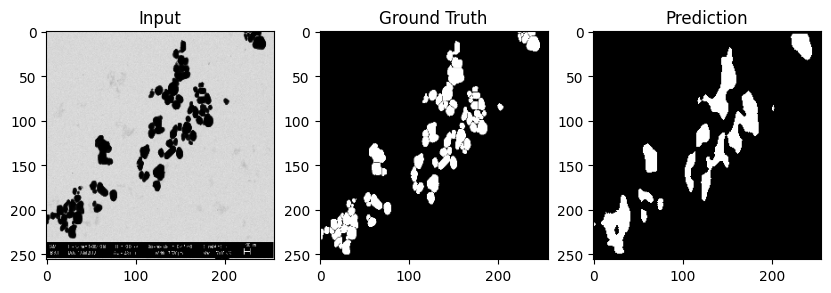

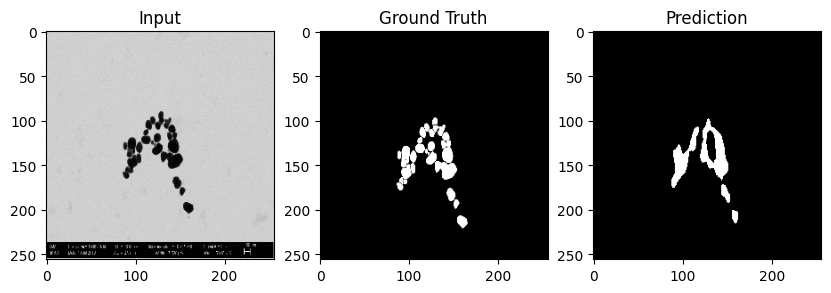

In [22]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for i in range(3):
        img, mask = dataset[i]
        pred = model(img.unsqueeze(0).cuda()).cpu().squeeze().numpy()

        plt.figure(figsize=(10,3))
        plt.subplot(1,3,1); plt.imshow(img.squeeze(), cmap='gray'); plt.title("Input")
        plt.subplot(1,3,2); plt.imshow(mask.squeeze(), cmap='gray'); plt.title("Ground Truth")
        plt.subplot(1,3,3); plt.imshow(pred > 0.5, cmap='gray'); plt.title("Prediction")
        plt.show()
